Number of matches in dataset (2018-2023): 388
Number of unique players: 366
Seasons included: [2018, 2019, 2020, 2021, 2022, 2023]

Top 20 players by average fantasy points (2018-2023, min 15 matches):
             fullName  Batting_FP  Bowling_FP  Fielding_FP   Total_FP  \
147          KL Rahul   56.379747    0.000000     6.075949  66.455696   
82       Devon Conway   55.136364    0.000000     3.181818  62.318182   
141       Jos Buttler   50.859155    0.000000     6.028169  60.887324   
25      Andre Russell   31.289474   22.434211     2.552632  60.276316   
75       David Warner   50.032258    0.000000     4.032258  58.064516   
95     Faf du Plessis   47.922078    0.000000     4.909091  56.831169   
198    Mitchell Marsh   27.277778   24.111111     1.333333  56.722222   
140    Jonny Bairstow   44.256410    0.000000     7.128205  55.384615   
247   Quinton de Kock   40.771429    0.000000     9.828571  54.600000   
270      Rishabh Pant   40.797297    0.000000     9.675676  54.47297

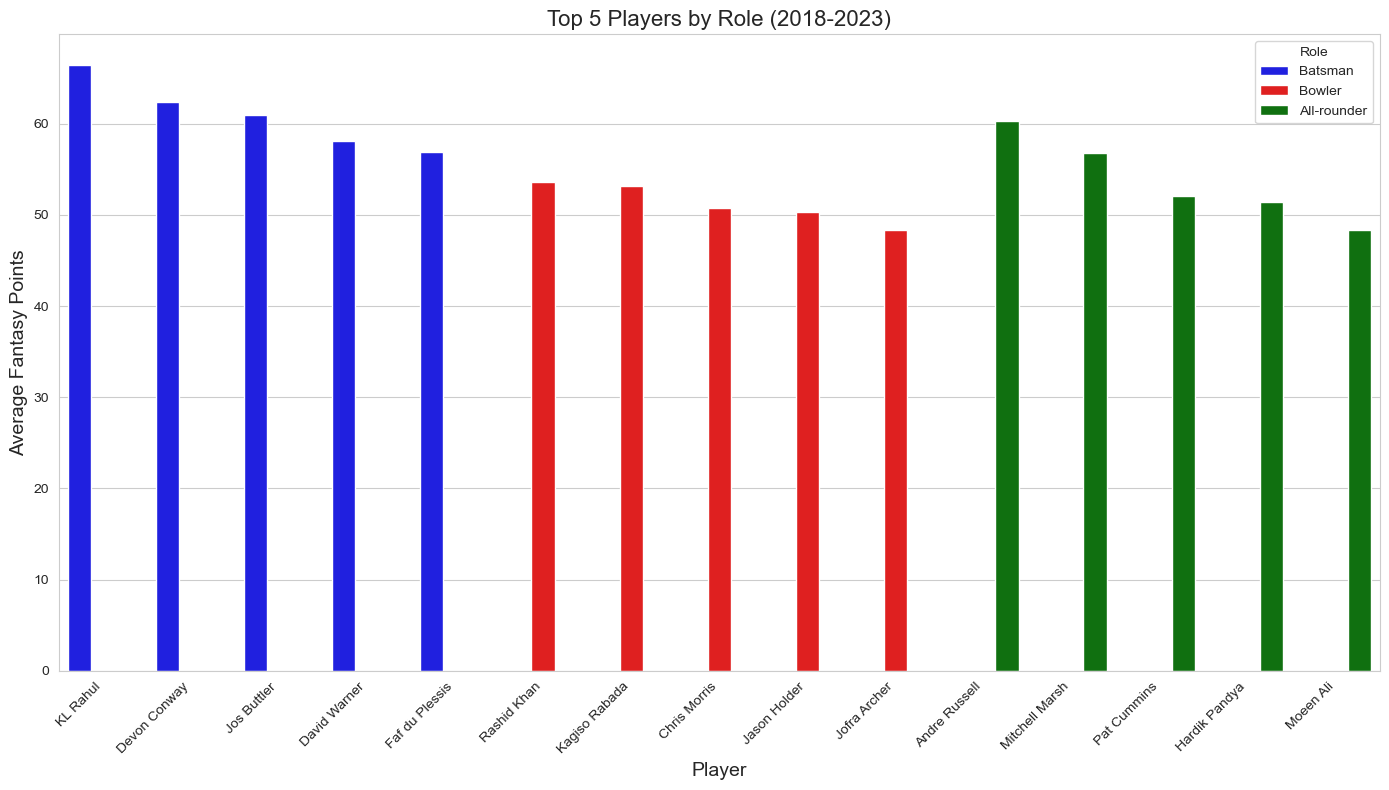

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
fantasy_data = pd.read_csv('FantasyData.csv')

# Filter data for recent seasons (2018-2023)
recent_data = fantasy_data[(fantasy_data['season'] >= 2018) & (fantasy_data['season'] <= 2023)]

# Display basic information about the filtered dataset
print(f"Number of matches in dataset (2018-2023): {recent_data['match_id'].nunique()}")
print(f"Number of unique players: {recent_data['fullName'].nunique()}")
print(f"Seasons included: {sorted(recent_data['season'].unique())}")

# Calculate average points by player across 2018-2023
player_avg = recent_data.groupby('fullName').agg({
    'Batting_FP': 'mean',
    'Bowling_FP': 'mean',
    'Fielding_FP': 'mean',
    'Total_FP': 'mean',
    'Starting_11': 'mean',  # Proportion of matches in starting 11
    'match_id': 'count',# Number of matches played
    'Credits': 'mean' ,
    'Nationality':'first'
}).reset_index()

# Rename columns for clarity
player_avg = player_avg.rename(columns={
    'match_id': 'matches_played',
    'Starting_11': 'starting_11_ratio'
})

# Only include players who played a meaningful number of matches (at least 15)
player_avg_filtered = player_avg[player_avg['matches_played'] >= 15]

# Sort by average Total_FP
player_avg_filtered = player_avg_filtered.sort_values(by='Total_FP', ascending=False)

# Display top 20 players by average fantasy points
print("\nTop 20 players by average fantasy points (2018-2023, min 15 matches):")
print(player_avg_filtered.head(20))

# Calculate player consistency
player_consistency = recent_data.groupby('fullName').agg({
    'Total_FP': ['mean', 'std', 'count']
}).reset_index()

# Calculate coefficient of variation (lower is more consistent)
player_consistency['cv'] = player_consistency[('Total_FP', 'std')] / player_consistency[('Total_FP', 'mean')]

# Only include players who played at least 15 matches
player_consistency = player_consistency[player_consistency[('Total_FP', 'count')] >= 15]

# Sort by mean Total_FP
player_consistency = player_consistency.sort_values(by=('Total_FP', 'mean'), ascending=False)

# Display top 20 consistent performers
print("\nTop 20 consistent performers (2018-2023, min 15 matches):")
print(player_consistency.head(20))

# Analyze player roles based on point distribution
player_avg_filtered['Batting_Ratio'] = player_avg_filtered['Batting_FP'] / player_avg_filtered['Total_FP']
player_avg_filtered['Bowling_Ratio'] = player_avg_filtered['Bowling_FP'] / player_avg_filtered['Total_FP']
player_avg_filtered['Fielding_Ratio'] = player_avg_filtered['Fielding_FP'] / player_avg_filtered['Total_FP']

# Classify players by their primary role
def classify_role(row):
    if row['Batting_Ratio'] > 0.6:
        return 'Batsman'
    elif row['Bowling_Ratio'] > 0.6:
        return 'Bowler'
    else:
        return 'All-rounder'

player_avg_filtered['Role'] = player_avg_filtered.apply(classify_role, axis=1)

# Display top players by role
print("\nTop 10 Batsmen:")
print(player_avg_filtered[player_avg_filtered['Role'] == 'Batsman'].head(10)[['fullName', 'Total_FP', 'Batting_FP', 'matches_played']])

print("\nTop 10 Bowlers:")
print(player_avg_filtered[player_avg_filtered['Role'] == 'Bowler'].head(10)[['fullName', 'Total_FP', 'Bowling_FP', 'matches_played']])

print("\nTop 10 All-rounders:")
print(player_avg_filtered[player_avg_filtered['Role'] == 'All-rounder'].head(10)[['fullName', 'Total_FP', 'Batting_FP', 'Bowling_FP', 'matches_played']])

# Let's also analyze performance trend over recent seasons
# We'll check if players have been improving or declining

# Calculate yearly averages for players who played in multiple seasons
player_yearly_avg = recent_data.groupby(['fullName', 'season']).agg({
    'Total_FP': 'mean',
    'match_id': 'count'
}).reset_index()

# Identify players who played in at least 2 of the last 3 seasons with sufficient matches
recent_seasons = [2021, 2022, 2023]
min_matches_per_season = 5

trending_players = {}
for player in player_avg_filtered['fullName'].unique():
    player_data = player_yearly_avg[(player_yearly_avg['fullName'] == player) & 
                                   (player_yearly_avg['season'].isin(recent_seasons)) &
                                   (player_yearly_avg['match_id'] >= min_matches_per_season)]
    
    if len(player_data) >= 2:
        trend = np.polyfit(player_data['season'], player_data['Total_FP'], 1)[0]
        trending_players[player] = trend

trend_df = pd.DataFrame(list(trending_players.items()), columns=['fullName', 'trend'])
trend_df = trend_df.sort_values(by='trend', ascending=False)

# Display players with strongest positive and negative trends
print("\nPlayers with improving performance (last 3 seasons):")
print(trend_df.head(10))

print("\nPlayers with declining performance (last 3 seasons):")
print(trend_df.tail(10))

# Visualize top performers by role
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Create color map
role_colors = {'Batsman': 'blue', 'Bowler': 'red', 'All-rounder': 'green'}

# Get top 5 players of each role
top_batsmen = player_avg_filtered[player_avg_filtered['Role'] == 'Batsman'].head(5)
top_bowlers = player_avg_filtered[player_avg_filtered['Role'] == 'Bowler'].head(5)
top_allrounders = player_avg_filtered[player_avg_filtered['Role'] == 'All-rounder'].head(5)

# Combine dataframes
top_players = pd.concat([top_batsmen, top_bowlers, top_allrounders])

# Create the plot
ax = sns.barplot(x='fullName', y='Total_FP', hue='Role', data=top_players, palette=role_colors)
plt.title('Top 5 Players by Role (2018-2023)', fontsize=16)
plt.xlabel('Player', fontsize=14)
plt.ylabel('Average Fantasy Points', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Role')
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import numpy as np
import pulp

# Function to find optimal XI with a predefined list of wicketkeepers
def find_optimal_xi(data, total_credits=100, overseas_limit=4, indian_limit=7,
                   min_wk=1, max_wk=4, req_bat=3, req_ar=3, req_bowl=4):
    
    # Define wicketkeepers:
    common_wicketkeepers = [
        'MS Dhoni', 'Rishabh Pant', 'KL Rahul', 'Ishan Kishan', 'Sanju Samson', 
        'Quinton de Kock', 'Jos Buttler', 'Jonny Bairstow', 'Nicholas Pooran', 'Heinrich Klaasen', 'Jitesh Sharma',
        'Dhruv Jurel', 'Abishek Porel', 'Phil Salt','Prabhsimran Singh','Rahmunallah Gurbaz','Devon Conway'
    ]
    
    # Create a copy of the data to avoid modifying the original
    df = data.copy()
    
    #Dropping Injured Player
    df = df[df['fullName'] != 'Umran Malik']
    
    # Drop players with missing credits
    df = df.dropna(subset=['Credits'])
    
    # Create a wicketkeeper flag
    df['is_wicketkeeper'] = df['fullName'].isin(common_wicketkeepers)
    
    # Define role including wicketkeeper
    def get_role(row):
        if row['is_wicketkeeper']:
            return 'Wicketkeeper'
        elif 'Role' in row:
            return row['Role']
        elif row.get('Batting_Ratio', 0) > 0.6:
            return 'Batsman'
        elif row.get('Bowling_Ratio', 0) > 0.6:
            return 'Bowler'
        else:
            return 'All-rounder'
    
    # Apply role classification
    df['Role'] = df.apply(get_role, axis=1)
    
    # Create the optimization problem (maximization)
    problem = pulp.LpProblem("FantasyCricketTeamSelection", pulp.LpMaximize)
    
    # Create binary variables for each player (1 if selected, 0 if not)
    player_vars = {player: pulp.LpVariable(f"player_{idx}", cat='Binary') for idx, player in enumerate(df['fullName'])}
    
    # Objective function: Maximize total fantasy points
    problem += pulp.lpSum(player_vars[player] * df.loc[df['fullName'] == player, 'Total_FP'].values[0] for player in player_vars.keys())
    
    # Constraint 1: Total credits should not exceed the limit
    problem += pulp.lpSum(player_vars[player] * df.loc[df['fullName'] == player, 'Credits'].values[0] for player in player_vars.keys()) <= total_credits
    
    # Constraint 2: Total number of players should be 11
    problem += pulp.lpSum(player_vars.values()) == 11
    
    # Constraint 3: Overseas players limit
    problem += pulp.lpSum(player_vars[player] for player in player_vars.keys() if df.loc[df['fullName'] == player, 'Nationality'].values[0] != 'India') <= overseas_limit
    
    # Constraint 4: Indian players requirement
    problem += pulp.lpSum(player_vars[player] for player in player_vars.keys() if df.loc[df['fullName'] == player, 'Nationality'].values[0] == 'India') == indian_limit
    
    # Constraints for roles
    for role, min_req, max_req in [('Wicketkeeper', min_wk, max_wk), ('Batsman', req_bat, req_bat), ('All-rounder', req_ar, req_ar), ('Bowler', req_bowl, req_bowl)]:
        role_players = [player for player in player_vars.keys() if df.loc[df['fullName'] == player, 'Role'].values[0] == role]
        problem += pulp.lpSum(player_vars[player] for player in role_players) >= min_req
        problem += pulp.lpSum(player_vars[player] for player in role_players) <= max_req
    
    # Solve the problem
    problem.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # Extract the optimal team
    optimal_team = [
        {
            'Name': player,
            'Role': df.loc[df['fullName'] == player, 'Role'].values[0],
            'Nationality': df.loc[df['fullName'] == player, 'Nationality'].values[0],
            'Credits': df.loc[df['fullName'] == player, 'Credits'].values[0],
            'Total_FP': df.loc[df['fullName'] == player, 'Total_FP'].values[0]
        }
        for player in player_vars.keys() if player_vars[player].value() == 1
    ]
    
    return optimal_team

# Function to analyze and display the optimal team
def analyze_team(team):
    roles, nations, total_credits, total_points = {}, {'India': 0, 'Overseas': 0}, 0, 0
    
    for player in team:
        roles[player['Role']] = roles.get(player['Role'], 0) + 1
        nations['India' if player['Nationality'] == 'India' else 'Overseas'] += 1
        total_credits += player['Credits']
        total_points += player['Total_FP']
    
    print(f"Optimal XI Fantasy Team:")
    print(f"Total Fantasy Points: {total_points:.2f}")
    print(f"Total Credits Used: {total_credits} / 100")
    print(f"Team Composition by Role: {roles}")
    print(f"Team Composition by Nationality: {nations}\n")
    
    for role in ['Wicketkeeper', 'Batsman', 'All-rounder', 'Bowler']:
        print(f"\n{role}s:")
        for player in sorted([p for p in team if p['Role'] == role], key=lambda x: -x['Total_FP']):
            print(f"- {player['Name']} ({player['Nationality']}) - {player['Credits']} credits, {player['Total_FP']:.2f} FP")

#Example usage
optimal_xi = find_optimal_xi(player_avg_filtered)
analyze_team(optimal_xi)


Optimal XI Fantasy Team:
Total Fantasy Points: 570.87
Total Credits Used: 100.0 / 100
Team Composition by Role: {'Wicketkeeper': 1, 'All-rounder': 3, 'Batsman': 3, 'Bowler': 4}
Team Composition by Nationality: {'India': 7, 'Overseas': 4}


Wicketkeepers:
- KL Rahul (India) - 10.0 credits, 66.46 FP

Batsmans:
- Faf du Plessis (South Africa) - 8.5 credits, 56.83 FP
- Ruturaj Gaikwad (India) - 10.5 credits, 54.00 FP
- Devdutt Padikkal (India) - 8.0 credits, 42.05 FP

All-rounders:
- Andre Russell (West Indies) - 10.0 credits, 60.28 FP
- Mitchell Marsh (Australia) - 9.0 credits, 56.72 FP
- Hardik Pandya (India) - 10.5 credits, 51.42 FP

Bowlers:
- Kagiso Rabada (South Africa) - 9.0 credits, 53.14 FP
- Harshal Patel (India) - 8.5 credits, 48.24 FP
- Mohit Sharma (India) - 9.0 credits, 46.20 FP
- Mayank Markande (India) - 7.0 credits, 35.53 FP
